In [ ]:
# """
# Key Ideas:
# -> Load the train, test data frame.
# -> Compute csr - train_csr.
# -> Perform SVD on train_csr.
# -> Perform NMF on train_csr.
# -> Select transactions to be used for Training.
# -> Collect the following features for the transactions:
#     * SVD val for the pair
#     * NMF val for the pair
#     * In-degree for sender
#     * Out-degree for sender
#     * In-degree for reciever
#     * Out-degree for reciever
#     * PageRank sender 
#     * PageRank reciever
#     * Part of same connected component?
#     * Closeness Centrality for sender
#     * Betweenness Centrality for sender
#     * Closeness Centrality for reciever
#     * Betweenness Centrality for reciever
#     * Jaccards for the pair
#     * Acad_ for the pair
# -> Train Classifier
# -> Collect same metrics from test transactions
# -> Generate Predictions
# -> Metrics: RoC, Accuracy, Confusion Matrix
# """

In [17]:
import numpy as np

from sklearn.decomposition import NMF
from scipy.sparse import csr_matrix, coo_matrix, linalg
import matplotlib.pyplot as plt
import itertools
import matplotlib

from sklearn.decomposition import TruncatedSVD
from scipy.sparse.linalg import svds

import random

import pandas as pd
from sklearn.metrics import roc_curve, auc

import networkx as nx




from itertools import cycle

from time import time
from operator import itemgetter

from sklearn.neighbors import KNeighborsClassifier

from sklearn.linear_model import LogisticRegressionCV, Perceptron

from sklearn.tree import DecisionTreeClassifier
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import  cross_val_score

from scipy.stats import randint as sp_randint

from sklearn.cluster import KMeans
from scipy.stats import mode

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier

from scipy import interp
from sklearn import svm
from sklearn.metrics import roc_curve, precision_recall_curve, auc, accuracy_score, classification_report, confusion_matrix, average_precision_score
from sklearn.naive_bayes import MultinomialNB

import time

ignore_colms = ['sender', 'receiver', 'transaction']
label_colm = 'transaction'

In [18]:
def load_data(convert_to_bin_trans):
    dftrain = pd.read_csv('data/txTripletsCounts.txt', header=None, index_col=None, sep=' ',
                          names=['sender','receiver','transaction'])
    dftest = pd.read_csv('data/testTriplets.txt', header=None, index_col=None, sep=' ',
                         names=['sender','receiver','transaction'])
    dim = max((dftrain['sender'].max(), dftrain['receiver'].max(), dftest['sender'].max(), dftest['receiver'].max()))
    dim += 1
    
    if convert_to_bin_trans:
        dftrain['transaction'] = np.array(dftrain['transaction'].tolist()).astype('bool').astype('int')
    
    train_csr = csr_matrix((dftrain['transaction'],(dftrain['sender'],dftrain['receiver'])), shape=(dim,dim), dtype=float)
    return dftrain, dftest, train_csr


def gen_nmf(A, n_components, save=False):
    nmf_model = NMF(n_components=n_components)
    W = nmf_model.fit_transform(A);
    H = nmf_model.components_;
    if save:
        save_sparse_csr("data/nmf_W_"+int(n_components), csr_matrix(W))
        save_sparse_csr("data/nmf_H_"+int(n_components), csr_matrix(H))
    return W, H


def get_predictions_svd(U, sigma, VT, df):
    pred = [np.sum(U[row['sender'],:] * sigma * VT[:,row['receiver']]) 
        for index,row in df[['sender', 'receiver']].iterrows()]
    return np.array(pred).astype(float)


def get_predictions_nmf(W, H, df):
    pred = [np.sum(W[row['sender'],:] * H[:,row['receiver']]) 
            for index,row in df[['sender', 'receiver']].iterrows()]
    return np.array(pred).astype(float)


def are_in_same_component(node1, node2, component_list):
    for component in component_list:
        if node1 in component or node2 in component:
            return node1 in component and node2 in component

        
def compute_graph_metrics(g, un_dir_g):
    print "Graph Centrality measures!"
    in_d = nx.centrality.in_degree_centrality(g)
    out_d = nx.centrality.out_degree_centrality(g)

    print "Graph PageRank!"
    pagerank = nx.pagerank(g)

    print "Graph Closeness & Betweenness!"
    closeness = nx.centrality.in_degree_centrality(g)
    betweenness = nx.centrality.out_degree_centrality(g)

    print "Graph Connected Comps!"
    cc = list(nx.connected_components(un_dir_g))
    print "Graph Strongly Connected Comps!"
    scc = list(nx.strongly_connected_components(g))
    print "Graph Weakly Connected Comps!"
    wcc = list(nx.weakly_connected_components(g))
    return in_d, out_d, pagerank, closeness, betweenness, cc, wcc, scc

        
def add_lin_alg_features(df, U, sigma, VT, W, H):
    df['svd_vals'] = get_predictions_svd(U, sigma, VT, df)
    df['nmf_vals'] = get_predictions_nmf(W, H, df)


def add_centrality_features(df, in_d, out_d, closeness, betweenness, pagerank):
    df['snd_in_degree'] = [in_d[i] for i in df['sender'].tolist()]
    df['rcv_in_degree'] = [in_d[i] for i in df['receiver'].tolist()]

    df['snd_out_degree'] = [out_d[i] for i in df['sender'].tolist()]
    df['rcv_out_degree'] = [out_d[i] for i in df['receiver'].tolist()]
    
    df['snd_closeness'] = [closeness[i] for i in df['sender'].tolist()]
    df['rcv_closeness'] = [closeness[i] for i in df['receiver'].tolist()]

    df['snd_betweenness'] = [betweenness[i] for i in df['sender'].tolist()]
    df['rcv_betweenness'] = [betweenness[i] for i in df['receiver'].tolist()]
    
    df['snd_pagerank'] = [pagerank[i] for i in df['sender'].tolist()]
    df['rcv_pagerank'] = [pagerank[i] for i in df['receiver'].tolist()]


def add_pair_features(df, pairs, un_dir_g, cc, scc, wcc):
    df['adamic'] = [x[2] for x in list(nx.adamic_adar_index(un_dir_g, pairs))]
    df['jaccard'] = [x[2] for x in list(nx.jaccard_coefficient(un_dir_g, pairs))]

    df['connected'] = np.array([are_in_same_component(pr[0], pr[1], cc) for pr in pairs]).astype('int')

    df['strng_connected'] = np.array([are_in_same_component(pr[0], pr[1], scc) for pr in pairs]).astype('int')

    df['wk_connected'] = np.array([are_in_same_component(pr[0], pr[1], wcc) for pr in pairs]).astype('int')


def get_random_traindf(dftrain, sender_count, receiver_count):
    random_senders = np.random.choice(dftrain['sender'].unique(), sender_count)
    random_receivers = np.random.choice(dftrain['receiver'].unique(), receiver_count)

    sender_ttxns = dftrain.loc[dftrain['sender'].isin(random_senders)]
    receiver_ttxns = dftrain.loc[dftrain['receiver'].isin(random_receivers)]

    ttxns = pd.concat([sender_ttxns, receiver_ttxns]).copy(deep=True)
    temp_pairs = zip(ttxns['sender'].tolist(), ttxns['receiver'].tolist())
    
    negative_txns_pairs = []
    for send, rec in itertools.product(range(len(random_senders)), range(len(random_receivers))):
        if (random_senders[send], random_receivers[rec]) not in temp_pairs:
            negative_txns_pairs.append([random_senders[send], random_receivers[rec], int(train_csr[random_senders[send], random_receivers[rec]])])

    ttxns = ttxns.append(pd.DataFrame(negative_txns_pairs, columns=['sender','receiver','transaction']))
    pairs = zip(ttxns['sender'].tolist(), ttxns['receiver'].tolist())
   
    return ttxns, pairs

In [19]:
def do_graph_cals(train_csr):
    # Graph based Computations
    g = nx.from_scipy_sparse_matrix(train_csr, create_using=nx.DiGraph())
    un_dir_g = nx.from_scipy_sparse_matrix(train_csr)
    print "G represent Done!"
    in_d, out_d, pagerank, closeness, betweenness, cc, wcc, scc = compute_graph_metrics(g, un_dir_g)
    print "Graph calcs Done!"
    return g, un_dir_g, in_d, out_d, pagerank, closeness, betweenness, cc, wcc, scc

In [20]:
def gen_feature_dfs(dftrain, dftest, train_csr, 
                    convert_to_bin_trans, svd_k, nmf_n, unq_senders, unq_receivers, 
                    g, un_dir_g, in_d, out_d, pagerank, closeness, betweenness, cc, wcc, scc):
    # Training Txns
    print "Training Txns selection!"
    train_txns, pairs = get_random_traindf(dftrain, unq_senders, unq_receivers)
    # Test Txn pairs
    test_pairs = zip(dftest['sender'].tolist(), dftest['receiver'].tolist())
    
    # Common computations for both train & test data
    # Perform SVD on train_csr.
    print "SVD!"
    U, sigma, VT = svds(train_csr, k=svd_k, tol=1e-10, which = 'LM')
    # Perform NMF on train_csr.
    print "NMF!"
    W, H = gen_nmf(train_csr, nmf_n)
    
    # Add Train Features
    print "Adding Train Features"
    add_lin_alg_features(train_txns, U, sigma, VT, W, H)
    add_centrality_features(train_txns, in_d, out_d, closeness, betweenness, pagerank)
    add_pair_features(train_txns, pairs, un_dir_g, cc, scc, wcc)
    
    # Add Test Features
    print "Adding Test Features"
    add_lin_alg_features(dftest, U, sigma, VT, W, H)
    add_centrality_features(dftest, in_d, out_d, closeness, betweenness, pagerank)
    add_pair_features(dftest, test_pairs, un_dir_g, cc, scc, wcc)
    
    # Save Data frames
    print "Saving DFs"
    filename_postfix = '_bin{}_svd{}_nmf{}_snd{}_rcv{}.csv'.format(str(convert_to_bin_trans), str(svd_k), str(nmf_n), str(unq_senders), str(unq_receivers))
    train_txns.to_csv('features/train' + filename_postfix)
    dftest.to_csv('features/test' + filename_postfix)
    
    return train_txns, dftest


def load_features_file(convert_to_bin_trans, svd_k, nmf_n, unq_senders, unq_receivers):
    filename_postfix = '_bin{}_svd{}_nmf{}_snd{}_rcv{}.csv'.format(str(convert_to_bin_trans), str(svd_k), str(nmf_n), str(unq_senders), str(unq_receivers))
    ftrain = pd.read_csv('features/train' + filename_postfix, index_col=0)
    ftest = pd.read_csv('features/test' + filename_postfix, index_col=0)
    return ftrain, ftest

In [21]:
def get_train_test_matricies(traindf, testdf):
    train_X = traindf.drop(ignore_colms, axis=1).as_matrix()
    train_Y = traindf[label_colm].values
    
    test_X = testdf.drop(ignore_colms, axis=1).as_matrix()
    test_true_Y = testdf[label_colm].values
    return train_X, train_Y, test_X, test_true_Y


# Function to run and get stats for any classifier
def simple_any(clf, train_features, train_labels, test_features, test_true_labels):
    start_time = time.time()
    stats = dict()
    clf = clf.fit(train_features, train_labels)

    train_predicted_labels = clf.predict(train_features)
    test_predicted_labels = clf.predict(test_features)

    y_score = clf.predict_proba(test_features)
    
    stats['false_pv_arr'], stats['true_pv_arr'], thresholds = roc_curve(test_true_labels, y_score[:, 1])
    stats['auc'] = auc(stats['false_pv_arr'], stats['true_pv_arr'])
    stats['precision_recall_f1'] = classification_report(test_true_labels, test_predicted_labels)
    stats['confusion_matrix'] = confusion_matrix(test_true_labels, test_predicted_labels)
    stats['test_accuracy'] = accuracy_score(test_true_labels, test_predicted_labels)
    return stats


def get_guess(cluster, kmeans, train_Y):
    inds = np.where(kmeans.labels_ == cluster)[0]
    return mode(train_Y[inds])[0][0]


def perform_k_means(train_X, train_Y, test_X, test_true_Y, num_clusters):
    kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(train_X)
    cluster_preds = kmeans.predict(test_X)

    guess_preds = np.array([get_guess(cl, kmeans, train_Y) for cl in cluster_preds])

    stats = dict()
    stats['false_pv_arr'], stats['true_pv_arr'], thresholds = roc_curve(test_true_Y, guess_preds)
    stats['auc'] = auc(stats['false_pv_arr'], stats['true_pv_arr'])
    stats['precision_recall_f1'] = classification_report(test_true_Y, guess_preds)
    stats['confusion_matrix'] = confusion_matrix(test_true_Y, guess_preds)
    stats['test_accuracy'] = accuracy_score(test_true_Y, guess_preds)
    return stats


def plt_all_clfs_roc(stats):
    colors = ['cyan', 'indigo', 'seagreen', 'yellow', 'blue', 'darkorange', 'red', 'magenta']

    plt.figure()
    lw = 2
    for i, stat_name in enumerate(stats):
        stat = stats[stat_name]
        plt.plot(stat['false_pv_arr'], stat['true_pv_arr'], 
            color=colors[i], lw=lw, label='{} (AUC = {})'.format(stat_name, round(stat['auc'],2)))
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()


def get_clfs():
    lr_clf = LogisticRegressionCV(Cs=list(np.power(10.0, np.arange(-4, 4))), penalty='l2', scoring='roc_auc')
    dt_clf = DecisionTreeClassifier()
    ab_clf = AdaBoostClassifier(learning_rate=0.5, n_estimators=50)
    svml_clf = svm.SVC(kernel='linear', C=1000, probability=True)
    svmr_clf = svm.SVC(kernel='rbf', C=10.0, gamma=10, probability=True)
    rf_clf = RandomForestClassifier(n_estimators=1000)
    knn_clf = KNeighborsClassifier(algorithm='kd_tree', n_neighbors=100)
    
    return [(lr_clf, "LR"), (dt_clf, "DT"), (ab_clf, "AB"), (svml_clf, "SVML"), 
        (svmr_clf, "SVMR"), (rf_clf, "RF"), (knn_clf, "KNN")]


def classify(train_X, train_Y, test_X, test_true_Y):
    results = {}
    for clf, name in get_clfs():
        results[name] = simple_any(clf, train_X, train_Y, test_X, test_true_Y)
    
    results["KMeans"] = perform_k_means(train_X, train_Y, test_X, test_true_Y, 1000)
    return results

In [5]:
# Configs
convert_to_bin_trans = True

svd_k = 50
nmf_n = 12

unq_senders = 250
unq_receivers = 100

# Load the train, test data frame.
dftrain, dftest, train_csr = load_data(convert_to_bin_trans)

In [6]:
g, un_dir_g, in_d, out_d, pagerank, closeness, betweenness, cc, wcc, scc = do_graph_cals(train_csr)

G represent Done!
Graph calcs Done!
Training Txns selection Done!
SVD Done!
NMF Done!


In [27]:
results = []
trials_count = 5

Training Txns selection!
SVD!
NMF!
Adding Train Features
Adding Test Features
Saving DFs
Matricies!
Classifying


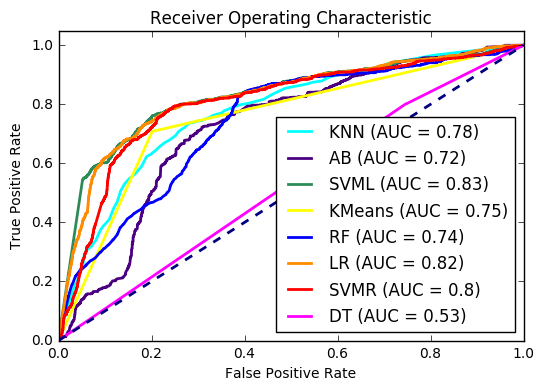

Training Txns selection!
SVD!
NMF!
Adding Train Features
Adding Test Features
Saving DFs
Matricies!
Classifying


In [ ]:
for trail in range(trials_count):    
    gen_traindf, gen_testdf = gen_feature_dfs(dftrain, dftest, train_csr, 
                                              convert_to_bin_trans, svd_k, nmf_n, unq_senders, unq_receivers,
                                              g, un_dir_g, in_d, out_d, pagerank, closeness, betweenness, cc, wcc, scc)
    
    print "Matricies!"
    train_X, train_Y, test_X, test_true_Y = get_train_test_matricies(gen_traindf, gen_testdf)

    print "Classifying"
    class_result = classify(train_X, train_Y, test_X, test_true_Y)
    plt_all_clfs_roc(class_result)

    results.append(class_result)